In [1]:
#Estudi total empresa 
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#tipus|delegacio|anysem|dia|mes|any|setmana|obert|festiu|venda|
df3 = pd.read_csv("vendes14.txt",delimiter="|",decimal=",",index_col='dia', parse_dates = True)
print(df3.head())


           tipus  delegacio  anysem  mes   any    setmana obert festiu  \
dia                                                                      
2018-05-10  BR01          1  201840   10  2018  divendres     S     no   
2018-09-10  BR01          1  201841   10  2018    dimarts     S     no   
2018-10-31  BR01          1  201844   10  2018   dimecres     S     no   
2018-11-11  BR01          1  201845   11  2018   diumenge     N     no   
2018-11-19  BR01          1  201847   11  2018    dilluns     S     no   

              venda  Unnamed: 10  
dia                               
2018-05-10  4657.12          NaN  
2018-09-10  3815.65          NaN  
2018-10-31  4415.77          NaN  
2018-11-11     0.00          NaN  
2018-11-19  3294.83          NaN  


In [2]:

#tipus|delegacio|anysem|dia|mes|any|setmana|obert|festiu|venda|
df2=df3.groupby(['anysem','tipus','setmana','festiu','delegacio'])['venda'].sum()
df2=df2.reset_index()

#sorting values of Data
df2=df2.sort_values(by='anysem')

In [3]:


dummy = pd.get_dummies(df2['tipus'])
df = pd.concat([df2, dummy], axis = 1)



dummy = pd.get_dummies(df2['festiu'])
df = pd.concat([df2, dummy], axis = 1)



dummy = pd.get_dummies(df2['setmana'])
df = pd.concat([df2, dummy], axis = 1)

#min_max_scaler = MinMaxScaler()
#vendes_values = df[['venda']]
#vendes_values = min_max_scaler.fit(vendes_values)
#df["venda"]=min_max_scaler.transform(df[['venda']])



In [4]:
#Llibreries necessaries
# dades
# ==============================================================================
import numpy as np
import pandas as pd
from tabulate import tabulate

# Gráfiques
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Preprocesat y modelat
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

# Varis
# ==============================================================================
import multiprocessing
import random
from itertools import product
from fitter import Fitter, get_common_distributions

In [5]:
# Configuracions matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuracions warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [6]:
#Aprofondim en l´estudi de les variables / distribuccions i correlacions

In [7]:
#Analitzem les distribucció de les dades de la variable ArrDelay

distribuciones = ['cauchy', 'chi2', 'expon',  'exponpow', 'gamma',
                  'norm', 'powerlaw', 'beta', 'logistic']

fitter = Fitter(df.venda, distributions=distribuciones)
fitter.fit()
print(fitter.summary(Nbest=10, plot=False))



          sumsquare_error           aic           bic    kl_div
logistic     1.045388e-09  5.786224e+03 -1.433679e+07       inf
cauchy       1.202050e-09  3.105150e+03 -1.427728e+07       inf
norm         1.630567e-09  1.479105e+04 -1.414734e+07       inf
expon        3.766597e-09  3.448004e+03 -1.379054e+07       inf
chi2         7.675741e-09           inf -1.348714e+07  1.916688
exponpow              inf           inf           inf       inf
gamma                 inf           inf           inf       inf
powerlaw              inf           inf           inf       inf
beta                  inf           inf           inf       inf


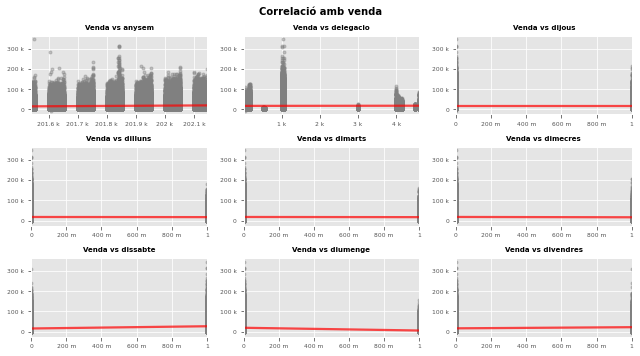

In [8]:
# Gráfico de correlació per cada variable numérica
# ==============================================================================

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_numeric = df.select_dtypes(include=['float64', 'int','int64','uint8']).columns
columnas_numeric = columnas_numeric.drop('venda')

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x           = df[colum],
        y           = df['venda'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"Venda vs {colum}", fontsize = 7, fontweight = "bold")
    #axes[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='both')
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlació amb venda', fontsize = 10, fontweight = "bold");

In [9]:
# Correlació entre columnes numériques
# ==============================================================================
#Correlació variables numériques
#Com s´ha estudiat alguns models (LM, GLM, ...) es veuen perjudicats si incorporen predictors altament correlacionats. 
# razón, es conveniente estudiar el grado de correlación entre las variables disponibles
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = df.select_dtypes(include=['float64', 'int','int64','uint8']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
28,venda,diumenge,-0.291690,0.291690
82,diumenge,venda,-0.291690,0.291690
72,dissabte,venda,0.237241,0.237241
27,venda,dissabte,0.237241,0.237241
39,dijous,divendres,-0.167067,0.167067
93,divendres,dijous,-0.167067,0.167067
83,diumenge,dijous,-0.167025,0.167025
38,dijous,diumenge,-0.167025,0.167025
98,divendres,diumenge,-0.166965,0.166965
89,diumenge,divendres,-0.166965,0.166965


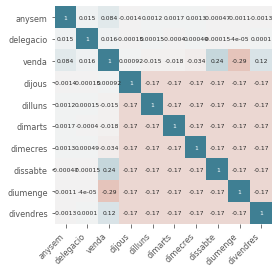

In [10]:
# Heatmap matriu de correlacions variables numeriques
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

In [11]:
# Repartim les dades en Train i test en base ArrDelay i les variables estudiades amb més bons resultats
# ==============================================================================


# Repartim les dades en Train i test en base ArrDelay
# ==============================================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(['venda','tipus','setmana','festiu'], axis = 'columns'),
                                        df['venda'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )


In [12]:

from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
#import multiprocessing

# Pipeline: preprocesat + model
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int','int64','uint8']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols)                    
                    ],
                    remainder='passthrough'
                )

#Pasos de preprocessat i modelat al mateix pipelin
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', Ridge())])

# Optimizació de hiperparámetres
# ==============================================================================
# Espai de busqueda de cada hiperparámetre
param_distributions = {'modelo__alpha': np.logspace(-5, 5, 500)}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
    
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3), 
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

print(grid)
# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('numeric',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['anysem',
                                                                                'delegacio',
                                                                                'dijous',
                                                                                'dilluns',
                                                                                'dimarts',

,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
1,56.690073,-15076.50203,50.140084,-15076.181498,12.518136


In [13]:
#Estudiant les dades amb regressió lineal i analitant MSE el millor hiperparametre alpha correspont a la sortida anterior

In [14]:
from sklearn.linear_model import Ridge

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
# Preprocedado
# ==============================================================================

# Identificación de columnas numéricas y categóricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int','int64','uint8']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )



preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols)
                    ],
                    remainder='passthrough'
                )

# Pipeline
# ==============================================================================

pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', Ridge())])

# Train
# ==============================================================================

_ = pipe.fit(X=X_train, y=y_train)
print(pipe)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['anysem', 'delegacio',
                                                   'dijous', 'dilluns',
                                                   'dimarts', 'dimecres',
                                                   'dissabte', 'diumenge',
                                                   'divendres'])])),
                ('modelo', Ridge())])


In [15]:
# Validació  creuada
# ==============================================================================
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )

print(f"Métricas validació  creuada: {cv_scores}")
print(f"Mitjana métricas de validació creuada: {cv_scores.mean()}")

Métricas validació  creuada: [-15016.48907877 -15097.22378662 -15082.46844627 -15111.21127565
 -15075.82104825]
Mitjana métricas de validació creuada: -15076.642727110922


In [16]:
# Validación cruzada repetida
# ==============================================================================
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=123)
cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = cv
             )

print(f"Métriques de validació creuada: {cv_scores}")
print("")
print(f"Mitjana metriques de validació creuada: {cv_scores.mean()}")

Métriques de validació creuada: [-15059.70805166 -15147.83720562 -15096.35090145 -15107.55776899
 -14970.72046866 -15161.64783601 -15005.8397731  -15044.03961025
 -14918.25018228 -15251.46499159 -15143.24049657 -15029.50128608
 -15019.76940503 -15145.5812853  -15044.45806959 -15154.22784354
 -14999.0017346  -15119.4950003  -15057.84370003 -15051.64989507
 -15078.52357532 -14897.335702   -15126.09993435 -15161.24189737
 -15118.89787299]

Mitjana metriques de validació creuada: -15076.411379509986


In [17]:
# Validació creuada repetida amb múltiples métricas
# ==============================================================================
from sklearn.model_selection import cross_validate

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=123)
cv_scores = cross_validate(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = ('r2', 'neg_root_mean_squared_error'),
                cv        = cv,
                return_train_score = True
            )

#Convertim el diccionari a dataframe per facilitar la visualtizació
cv_scores = pd.DataFrame(cv_scores)
cv_scores

,fit_time,score_time,test_r2,train_r2,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
0,0.417388,0.078429,0.139827,0.143048,-15075.735083,-15076.533546
1,0.416172,0.062497,0.142533,0.141685,-15143.418801,-15042.627245
2,0.395391,0.091754,0.143496,0.141226,-15009.921417,-15109.306948
3,0.353143,0.093733,0.139963,0.142992,-15127.964486,-15050.327953
4,0.265560,0.056105,0.143318,0.141305,-14989.766892,-15119.342517
5,0.206439,0.046863,0.142577,0.141665,-15111.317484,-15058.765886
6,0.216469,0.046862,0.140755,0.142587,-15160.191475,-15034.161041
7,0.167646,0.046867,0.143621,0.141161,-14993.506708,-15117.501523
8,0.187454,0.031243,0.141468,0.142224,-15075.532702,-15076.699701
9,0.175782,0.031240,0.141233,0.142345,-15070.198300,-15079.316437


In [18]:
# Validació creuada repetida paralelitzada paralelizada (multicore)
# ==============================================================================
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = cv,
                n_jobs    = -1 # todos los cores disponibles
             )

print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Média métricas de validación cruzada: -15075.964125941575


In [19]:
predicciones = pipe.predict(X_test)

In [20]:
# Se crea un dataframe con las predicciones y el valor real
df_predicciones = pd.DataFrame({'venda' : y_test, 'prediccion' : predicciones})
df_predicciones.head()

,venda,prediccion
77952,5085.99,15641.256193
179366,12938.91,16372.203102
385013,10255.11,28725.622379
112381,20780.52,25626.590047
182836,26787.20,21712.736689


In [21]:
# neg_root_mean_squared_error de test
# ==============================================================================
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(
        y_true = y_test,
        y_pred = predicciones,
        squared = False
       )
print(rmse)

15056.46806101015


In [22]:
#Hiperparámetres (tuning)
#Escollir un conjunt de valors pel hiperparametres

#grid search: es fa una búsqueda exhaustiva sobre el conjunt de 
#valors previaments definits per usuari 

#random search: evaluen valors aletoris dins de limits definits per usuari

#Per cada valor (combinació si més un hiperparámetre), entrenar el model i estimar el seu error mitjançant
#un metode de validació 

#Finalment ajusta de nou el model, amb les dades dentranament i els millor hiperparametres trobats


In [23]:

#El modelo Ridge (model lineal) utilitzat fins ara té un hiperparametre anomenat alpha  
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.linear_model import Ridge

# Pipe: preprocesat + model
# ==============================================================================

numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()


# Transformacions per les variables numeriques 
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols)
                    ],
                    remainder='passthrough'
                )

pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', Ridge())])

# Grid de hiperparametres
# ==============================================================================
param_grid = {'modelo__alpha': np.logspace(-5, 3, 10)}

# Búsqueda per validació creauada 
# ==============================================================================
grid = GridSearchCV(
        estimator  = pipe,
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 5), 
        verbose    = 0,
        return_train_score = True
       )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = X_train, y = y_train)
print(grid)

GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=None),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['anysem',
                                                                          'delegacio'])])),
                                       ('modelo', Ridge())]),
             n_jobs=3,
             param_grid={'modelo__alpha': array([1.00000000e-05, 7.74263683e-05, 5.99484250e-04, 4.64158883e-03,
       3.59381366e-02, 2.78255940e-01, 2.15443469e+00, 1.66810054e+01,
       1.29154967e+02, 1.00000000e+03])},
   

In [24]:
# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)

,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
6,2.154435,-15076.205328,114.649028,-15076.153331,28.615441
5,0.278256,-15076.205346,114.648218,-15076.153328,28.615441
4,0.035938,-15076.205349,114.648113,-15076.153327,28.615441
3,0.004642,-15076.205349,114.648099,-15076.153327,28.615441
2,0.000599,-15076.205349,114.648098,-15076.153327,28.615441
1,0.000077,-15076.205349,114.648097,-15076.153327,28.615441
0,0.00001,-15076.205349,114.648097,-15076.153327,28.615441
7,16.681005,-15076.205370,114.655299,-15076.153544,28.615441
8,129.154967,-15076.216758,114.703589,-15076.166253,28.615455
9,1000.0,-15076.935379,115.062146,-15076.894790,28.616231


In [25]:
# Mejores hiperparámetros
# ==============================================================================
print("-----------------------------------")
print("Mejores hiperparámetros encontrados")
print("-----------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

-----------------------------------
Mejores hiperparámetros encontrados
-----------------------------------
{'modelo__alpha': 2.154434690031882} : -15076.20532769501 neg_root_mean_squared_error


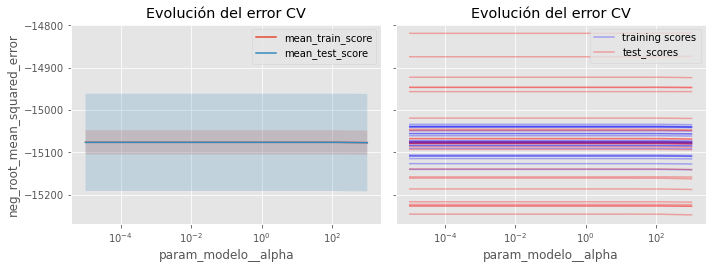

In [26]:
# Gráfico resultados validación cruzada para cada hiperparámetro
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.84), sharey=True)

# Gráfico 1
# ------------------------------------------------------------------------------
resultados.plot('param_modelo__alpha', 'mean_train_score', ax=axes[0])
resultados.plot('param_modelo__alpha', 'mean_test_score', ax=axes[0])
axes[0].fill_between(resultados.param_modelo__alpha.astype(np.float),
                resultados['mean_train_score'] + resultados['std_train_score'],
                resultados['mean_train_score'] - resultados['std_train_score'],
                alpha=0.2)
axes[0].fill_between(resultados.param_modelo__alpha.astype(np.float),
                resultados['mean_test_score'] + resultados['std_test_score'],
                resultados['mean_test_score'] - resultados['std_test_score'],
                alpha=0.2)
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_title('Evolución del error CV')
axes[0].set_ylabel('neg_root_mean_squared_error');

# Gráfico 2
# ------------------------------------------------------------------------------
numero_splits = grid.n_splits_

resultados.plot(
    x     = 'param_modelo__alpha',
    y     = [f'split{i}_train_score' for i in range(numero_splits)],
    alpha = 0.3,
    c     = 'blue', 
    ax    = axes[1]
)

resultados.plot(
    x     = 'param_modelo__alpha',
    y     = [f'split{i}_test_score' for i in range(numero_splits)],
    alpha = 0.3,
    c     = 'red', 
    ax    = axes[1]
)

axes[1].legend(
    (axes[1].get_children()[0], axes[1].get_children()[numero_splits]),
    ('training scores', 'test_scores')
)
axes[1].set_xscale('log')
axes[1].set_title('Evolución del error CV')
axes[1].set_ylabel('neg_root_mean_squared_error');

fig.tight_layout()

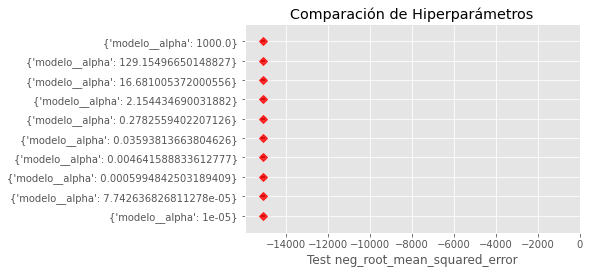

In [27]:
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.barh(
    [str(d) for d in resultados['params']],
    resultados['mean_test_score'],
    xerr=resultados['std_test_score'],
    align='center',
    alpha=0
)
ax.plot(
    resultados['mean_test_score'],
    [str(d) for d in resultados['params']],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Comparación de Hiperparámetros')
ax.set_xlabel('Test neg_root_mean_squared_error');

In [28]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

# Espacio de búsqueda de cada hiperparámetro
# ==============================================================================
param_distributions = {'modelo__alpha': np.logspace(-5, 3, 100)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 50,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 5), 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
1,4.534879,-15076.454302,74.789764,-15076.169055,18.707785


In [29]:
#optimitzacio Bayesiana
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

espacio_busqueda  = [Real(1e-6, 1e+3, "log-uniform", name='modelo__alpha')]

@use_named_args(espacio_busqueda)
def objective(**params):
    pipe.set_params(**params)
    return -np.mean(cross_val_score(pipe, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_root_mean_squared_error"))

resultados_opt = gp_minimize(
                    func         = objective,
                    dimensions   = espacio_busqueda,
                    n_calls      = 50,
                    random_state = 0
                )

print(f"Mejor score validación: {resultados_opt.fun}")
print(f"Mejores hiperparámetros: {list(zip([x.name for x in espacio_busqueda], resultados_opt.x))}")

Mejor score validación: 15076.642693140038
Mejores hiperparámetros: [('modelo__alpha', 7.273593662110231)]


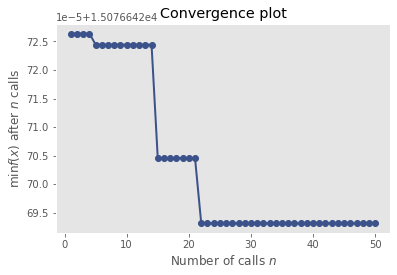

In [30]:
# Evolución de la optimización
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3.84))
plot_convergence(resultados_opt, ax = ax);

In [31]:
#Tuning del preprocesado
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_selector

# Pipe: preprocesado + modelo
# ==============================================================================
# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )


preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, make_column_selector(dtype_include=np.number))
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline(
        [('preprocessing', preprocessor),
        ('interactions', PolynomialFeatures(degree=2)),
        ('modelo', Ridge())])

# Grid de hiperparámetros
# ==============================================================================
param_grid = {'interactions': [PolynomialFeatures(degree=2), 'passthrough'],
              'modelo__alpha': np.logspace(-5, 3, 10)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = pipe,
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 5), 
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

print(grid)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=None),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001412937CA00>)])),
                                       ('interactions', PolynomialFeatures()),
                                       ('modelo', Ridge())]),
             n_jobs=3,
             param_grid={'interactions': [PolynomialFeatures(), 'passthrough'],
                         'modelo__alpha': array([1.00000000e-05, 7.74263683e-05,

,param_interactions,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
6,PolynomialFeatures(),2.154435,-13924.145144,73.939007,-13923.240422,18.456781


In [ ]:
#KNN
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )


preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', KNeighborsRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro
param_distributions = {'modelo__n_neighbors': np.linspace(1, 100, 500, dtype=int)}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3), 
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

print(grid)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

In [ ]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_knn = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print(f"El error (rmse) de test es: {rmse_knn}")

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )


preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', RandomForestRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__n_estimators': [50, 100, 1000, 2000],
    'modelo__max_features': ["auto", 3, 5, 7],
    'modelo__max_depth'   : [None, 3, 5, 10, 20]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)
print(grid)
# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

In [ ]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_rf = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_rf}")

In [ ]:
#Gradient Boosting Trees
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )


preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', GradientBoostingRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__n_estimators': [50, 100, 1000, 2000],
    'modelo__max_features': ["auto", 3, 5, 7],
    'modelo__max_depth'   : [None, 3, 5, 10, 20],
    'modelo__subsample'   : [0.5,0.7, 1]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)
print(grid)
# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

In [ ]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_gbm = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_gbm}")

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

# Pipeline: preprocesado + modelos para el stacking
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),                 
                    ],
                    remainder='passthrough'
                )
# Se combinan los pasos de preprocesado y los modelos creando varios pipeline.
pipe_ridge = Pipeline([('preprocessing', preprocessor),
                     ('ridge', Ridge(alpha=3.4))])

pipe_rf = Pipeline([('preprocessing', preprocessor),
                     ('random_forest', RandomForestRegressor(
                                         n_estimators = 1000,
                                         max_features = 2,
                                         max_depth    = 20
                                        )
                     )])

In [ ]:

estimators = [('ridge', pipe_ridge),
              ('random_forest', pipe_rf)]

stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = stacking_regressor.fit(X = X_train,y = y_train)

print(stacking_regressor)
# Error de test del stacking
# ==============================================================================
modelo_final = stacking_regressor
predicciones = modelo_final.predict(X = X_test)
rmse_stacking = mean_squared_error(
                    y_true  = y_test,
    
                    y_pred  = predicciones,
                    squared = False
                  )
print(f"El error (rmse) de test es: {rmse_stacking}")

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.linear_model import Ridge

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )
preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', Ridge())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro
param_distributions = {'modelo__alpha': np.logspace(-5, 5, 500)}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3), 
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)
print(grid)
# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

In [ ]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_lm = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_lm}")

In [ ]:
error_modelos = pd.DataFrame({
                        'modelo': ['knn', 'lm', 'random forest', 'gradient boosting',
                                   'stacking'],
                        'rmse': [rmse_knn, rmse_lm, rmse_rf, rmse_gbm, rmse_stacking]
                     })
#error_modelos = pd.DataFrame({
 #                       'modelo': ['knn', 'lm','random forest', 'gradient boosting'],
 #                       'rmse': [rmse_knn, rmse_lm, rmse_rf, rmse_gbm]
 #                    })


error_modelos = error_modelos.sort_values('rmse', ascending=False)

fig, ax = plt.subplots(figsize=(6, 3.84))
ax.hlines(error_modelos.modelo, xmin=0, xmax=error_modelos.rmse)
ax.plot(error_modelos.rmse, error_modelos.modelo, "o", color='black')
ax.tick_params(axis='y', which='major', labelsize=12)
ax.set_title('Comparación de error de test modelos'),
ax.set_xlabel('Test rmse');

In [ ]:

# Error de test del modelo final
# ==============================================================================
from sklearn.metrics import mean_squared_error
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_lm = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_lm}")